# Epipolar Geometry

_Tiffany Wang - 260684152_

In [1]:
import cv2
import numpy as np
import math
import matplotlib.pyplot as plt

In [2]:
def plot_figs(imgs, titles=None, max_col=4):
    """
    Plots list of images in a grid. 
    -----
    args imgs: list of images.
    args titles: list of titles, defaults to None.
    args max_col: number of column in the grid, defaults to 4.
    -----
    return: None.
    """
    n = len(imgs)
    
    # Each plot can hold up to 8 images.
    rows_per_set = 8 // max_col 
    fig_per_set = rows_per_set * max_col
    sets = math.ceil(n / fig_per_set)
    
    for s in range(sets):
        # starting index of your set
        start = s * fig_per_set
        
        # compute the number of images and rows in the current set 
        subset_len = min(start+fig_per_set, n) - start
        nb_rows = math.ceil(subset_len / max_col)
        
        # set subplot map 
        subplot = "{}{}".format(nb_rows, max_col)
        plt.figure(figsize=(20, 4 * nb_rows))
        for i in range(subset_len):
            plt.subplot(int("{}{}".format(subplot, i+1)))
            if titles is not None: 
                plt.title(titles[start + i])
            else:
                plt.title(str(start + i + 1))
            plt.axis('off')
            plt.imshow(imgs[start + i].astype(np.uint8))
    plt.show()

In [3]:
def drawlines(img1, img2, lines, pts1, pts2):
    """
    Draw epilines corresponding to the points in the first image on 
    second image. 
    -----
    args img1: first image. 
    args img2: second image. 
    args lines: corresponding epilines.
    args pts1: keypoints of the first image. 
    args pts2: keypoints of the second image.
    -----
    returns: images with the epilines. 
    """
    
    # Get shape of first image, asume grayscale
    row, col, _ = img1.shape
    
    # Create copies to not overwrite the original image
    img1_c = img1.copy()
    img2_c = img2.copy()
    
    # draw the lines
    for r, pt1, pt2 in zip(lines, pts1, pts2):
        # pick a random color for the line
        color = tuple(np.random.randint(0, 255, 3).tolist())
        x0, y0 = map(int, [0, -r[2]/r[1]])
        x1, y1 = map(int, [col, -(r[2]+r[0]*col)/r[1]])
        
        # draw the lines and the points
        img1_c = cv2.line(img1_c, (x0,y0), (x1,y1), color, 4)
        img1_c = cv2.circle(img1_c, tuple(pt1), 15, color, -1)
        img2_c = cv2.circle(img2_c, tuple(pt2), 15, color, -1)
    return img1_c, img2_c

###### Compute matching SIFT keypoints from a stereo image pair.

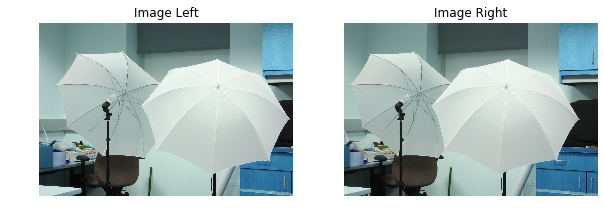

In [4]:
# Load stereo images

imgL = cv2.imread("im0.png")
imgR = cv2.imread("im1.png")

plt.figure(figsize=(10, 5))
plt.subplot(121)
plt.title('Image Left')
plt.imshow(imgL, cmap='gray'), plt.axis('off')
plt.subplot(122)
plt.title('Image Right')
plt.imshow(imgR, cmap='gray'), plt.axis('off')
plt.show()

In [10]:
# Find SIFT keypoints and matches between the stereo images 

sift = cv2.xfeatures2d.SIFT_create()
bf = cv2.BFMatcher(cv2.NORM_L2)

# find keypoints and descriptors
kpL, desL = sift.detectAndCompute(imgL, None)
kpR, desR = sift.detectAndCompute(imgR, None)

# get top 2 matches between the two images 
matches = bf.knnMatch(desL, desR, k=2)

# Apply threshold to select 'good' matches 
thres = 0.6
good_matches = []
good_ptsL, good_ptsR = [], []
bad_matches = []
bad_ptsL, bad_ptsR = [], []


for _, (m, n) in enumerate(matches):
    if m.distance < thres * n.distance: 
        good_matches.append(m)
        good_ptsR.append(kpR[m.trainIdx].pt)
        good_ptsL.append(kpL[m.queryIdx].pt)   
    else: 
        bad_matches.append(m)
        bad_ptsR.append(kpR[m.trainIdx].pt)
        bad_ptsL.append(kpL[m.queryIdx].pt)  

good_ptsL = np.int32(good_ptsL)
good_ptsR = np.int32(good_ptsR)
bad_ptsL = np.int32(bad_ptsL)  
bad_ptsR = np.int32(bad_ptsR)

# Print out stats
print("Total number of keypoints in imgL: {}".format(len(kpL)))
print("Total number of keypoints in imgR: {}".format(len(kpR)))
print("Total number of matches: {}".format(len(matches)))
print("Number of good matches with a threshold of {}: {}".format(thres, len(good_matches)))
print("Number of bad matches with a threshold of {}: {}".format(thres, len(bad_matches)))

Total number of keypoints in imgL: 1134
Total number of keypoints in imgR: 976
Total number of matches: 1134
Number of good matches with a threshold of 0.6: 346
Number of bad matches with a threshold of 0.6: 788


###### Compute and display the epipolar lines for both images.¶

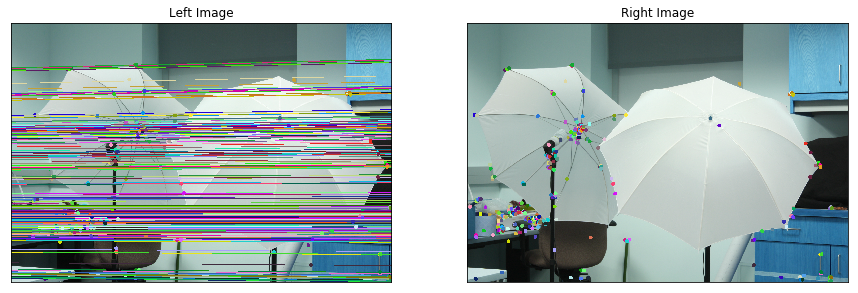

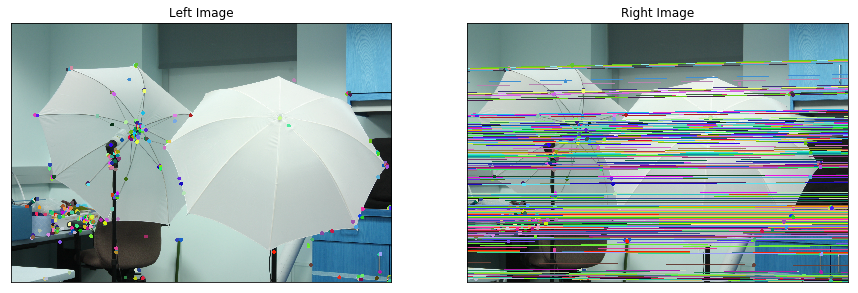

In [7]:
# Get fundamental matrix of the good matches
F, _ = cv2.findFundamentalMat(good_ptsL, good_ptsR, cv2.FM_LMEDS)

# Compute epilines of first image on the second image.
linesL = cv2.computeCorrespondEpilines(good_ptsR, 2, F)
linesL = linesL.reshape(-1, 3)

# Draw epilines on the images. 
imgL1, imgR1 = drawlines(imgL, imgR, linesL, good_ptsL, good_ptsR)

# Compute epilines of second image on the first image.
linesR = cv2.computeCorrespondEpilines(good_ptsL, 2, F)
linesR = linesR.reshape(-1, 3)

# Draw epilines on the images. 
imgR2, imgL2 = drawlines(imgR, imgL, linesR, good_ptsR, good_ptsL)

# display images
plt.figure(figsize=(15,15))
plt.subplot(121), plt.imshow(imgL1, cmap="gray")
plt.title("Left Image"), plt.xticks([]), plt.yticks([])

plt.subplot(122), plt.imshow(imgR1, cmap="gray")
plt.title("Right Image"), plt.xticks([]), plt.yticks([])

plt.figure(figsize=(15,15))
plt.subplot(121), plt.imshow(imgL2, cmap="gray")
plt.title("Left Image"), plt.xticks([]), plt.yticks([])

plt.subplot(122), plt.imshow(imgR2, cmap="gray")
plt.title("Right Image"), plt.xticks([]), plt.yticks([])
plt.show()

###### Pick any one keypoint in the right image which doesn't have a correct match in the left image, and is not on the corresponding epipolar line. Extract a patch of size (5 x 5) around this keypoint in the right image. 

In [135]:
def extract_patches_list(img, kp, size=(5, 5)):
    """
    Extracts list of patches along a horizontal line given a reference keypoint. 
    -----
    args img: The image to get patches from. 
    args kp: Reference keypoint. 
    args size: Patch size, defaults to (5, 5).
    -----
    Returns: list of patches. 
    """
    x, y = kp
    h, w, _ = img.shape
    s, e = size[0] // 2, size[1] // 2 + 1
    patch_list = []
    
    for col in range(s, w - e):
        patch = img[y-s:y+e,col-s:col+e]
        patch_list.append(patch)
    return patch_list

def extract_patch(img, kpt, size=(5, 5)):
    """
    Extract patch from an image. 
    -----
    args img: Image to extract from. 
    args kpt: Center of the patch. 
    args size: size of the patch, defaults to (5, 5).
    -----
    returns: patch. 
    """
    x, y = kpt[0], kpt[1]
    h, w = size
    x_s, x_e = x - (w//2), x + (w - w//2)
    y_s, y_e = y - (h//2), y + (h - h//2)
    return img[y_s:y_e, x_s:x_e]

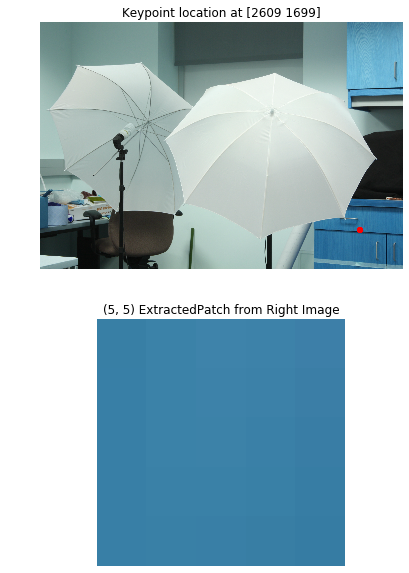

In [136]:
# We take the feature point corresponding to the patch of hair of the doll on the chair,
# corresponding to the point bad_ptsR at index 0

# Extract patch around keypoint
selected_kp = bad_ptsR[0]
patch_extracted = extract_patch(imgR, selected_kp)

display = imgR.copy()
display = cv2.circle(display, tuple(selected_kp), 25, (255, 0, 0), -1)

# Display patches
plt.figure(figsize=(20,10))
plt.subplot(211), plt.title('Keypoint location at {}'.format(selected_kp))
plt.imshow(display), plt.axis('off')
plt.subplot(212), plt.title("{} ExtractedPatch from Right Image".format((5, 5))), plt.xticks([]), plt.yticks([])
plt.imshow(patch_extracted), plt.axis('off')
plt.show()

###### Match the extracted patch using the sum of squared difference (SSD) with every patch along the corresponding epipolar line in the left image.

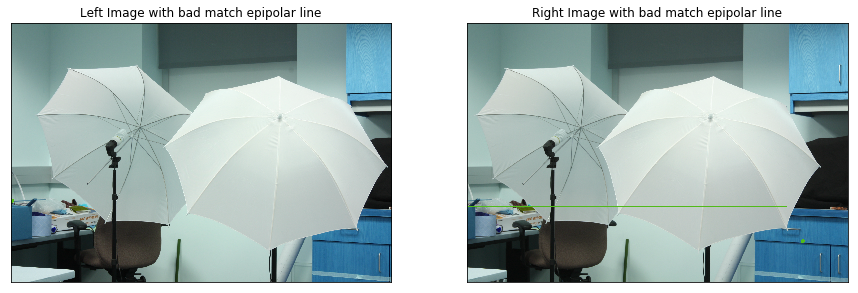

In [137]:
F, _ = cv2.findFundamentalMat(bad_ptsL, bad_ptsR, cv2.FM_LMEDS)

# Compute epilines of first image on the second image.
linesL = cv2.computeCorrespondEpilines(bad_ptsR[:1], 2, F)
linesL = linesL.reshape(-1, 3)

bad_imgR, bad_imgL = drawlines(imgR, imgL, linesR, bad_ptsR[:1], bad_ptsL[:1])
plt.figure(figsize=(15,15))
plt.subplot(121), plt.imshow(bad_imgL)
plt.title("Left Image with bad match epipolar line"), plt.xticks([]), plt.yticks([])

plt.subplot(122), plt.imshow(bad_imgR)
plt.title("Right Image with bad match epipolar line"), plt.xticks([]), plt.yticks([])
plt.show()

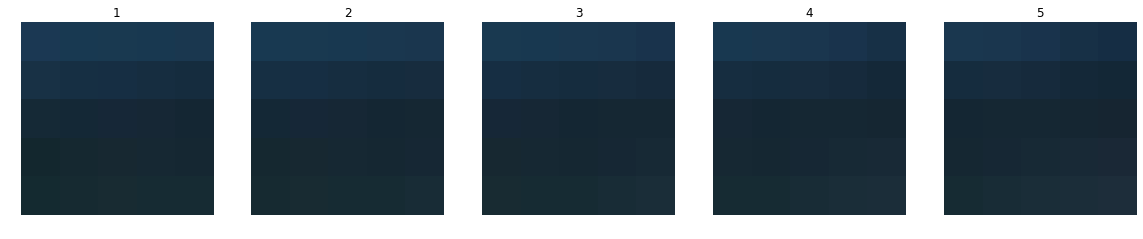

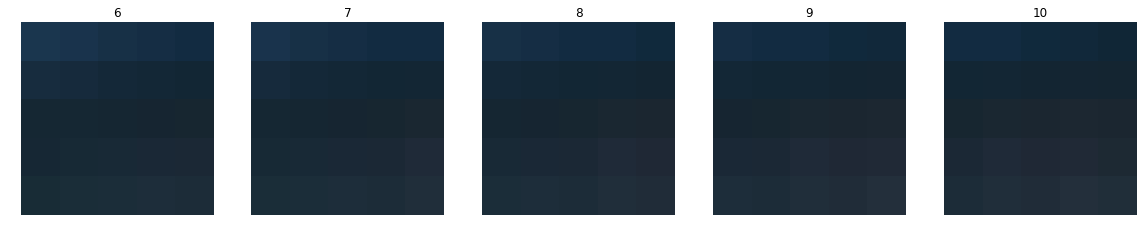

In [138]:
# Epipolar lines are horizonal. Extract the patches along the row of the selected keypoint.
patches_left = extract_patches_list(imgL, selected_kp)

# Plot first 10 patches
plot_figs(patches_left[:10], None, max_col=5)

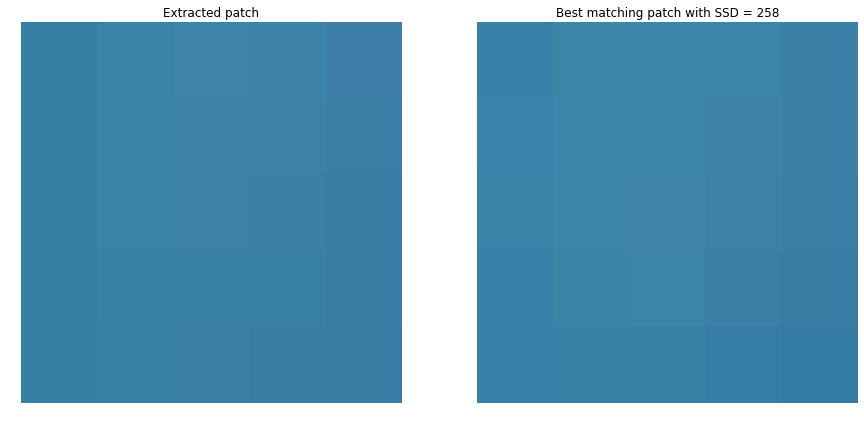

In [153]:
# Method that takes in list of patches, and computes SSD distance between extracted patch and list of patches

def computeSSD(patch_list, patch_ref):
    """
    Computes the SSD between the patch_list and the reference patch and displays the best match. 
    -----
    args patch_list: List of patches. 
    args patch_ref: Reference patch. 
    -----
    Returns: 
    SSD: list of SSD between each patch in the patch_list and the reference 
    best_match: the patch with the lowest SSD. 
    min_idx: the column number of the center of the best_match
    """
    SSD = []
    for i in range(len(patch_list)):
        # Compute min value of SSD in the image
        patch_curr = patch_list[i]
        SSD_curr = np.sum((patch_ref-patch_curr)**2)
        SSD.append(SSD_curr)    
    min_idx = SSD.index(min(SSD))
    best_match = patch_list[min_idx]
    
    # Display extracted 
    plt.figure(figsize=(15,15))
    plt.subplot(121), plt.title("Extracted patch")
    plt.imshow(patch_ref), plt.axis('off')
    plt.subplot(122), plt.title("Best matching patch with SSD = {}".format(SSD[min_idx]))
    plt.imshow(best_match), plt.axis('off')
        
    x, y, _ = patch_ref.shape
    return SSD, best_match, min_idx + y // 2

SSD_list, best_match, min_idx = computeSSD(patches_left, patch_extracted)

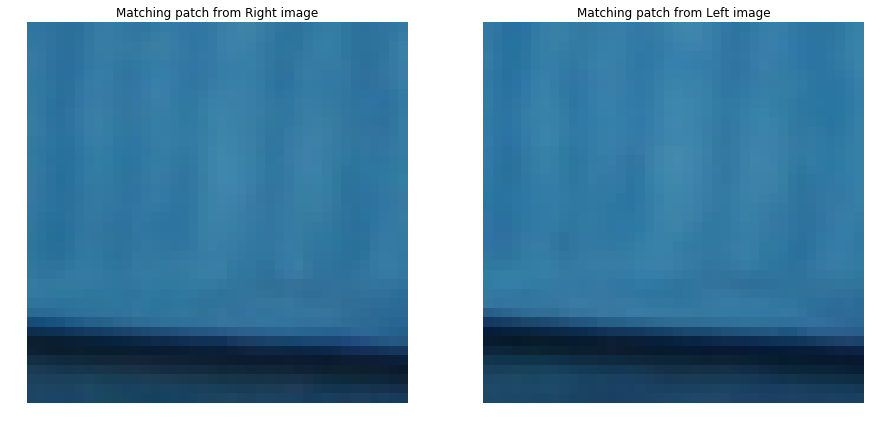

In [168]:
x, y = selected_kp
best_match_patch_center = (min_idx, y)

imgR_extract = extract_patch(imgR, selected_kp, size=(40, 40))
imgL_extract = extract_patch(imgL, best_match_patch_center, size=(40, 40))

# Display extracted 
plt.figure(figsize=(15,15))
plt.subplot(121), plt.title("Matching patch from Right image") 
plt.imshow(imgR_extract), plt.axis('off')
plt.subplot(122), plt.title("Matching patch from Left image") 
plt.imshow(imgL_extract), plt.axis('off')
plt.show()
        

/Users/TiffanyWang/Documents/Assignments/compvision/lib/python3.7/site-packages/matplotlib/axes/_base.py:3449: MatplotlibDeprecationWarning: 
The `ymin` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `bottom` instead.
  alternative='`bottom`', obj_type='argument')
/Users/TiffanyWang/Documents/Assignments/compvision/lib/python3.7/site-packages/matplotlib/axes/_base.py:3116: MatplotlibDeprecationWarning: 
The `xmin` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `left` instead.
  alternative='`left`', obj_type='argument')


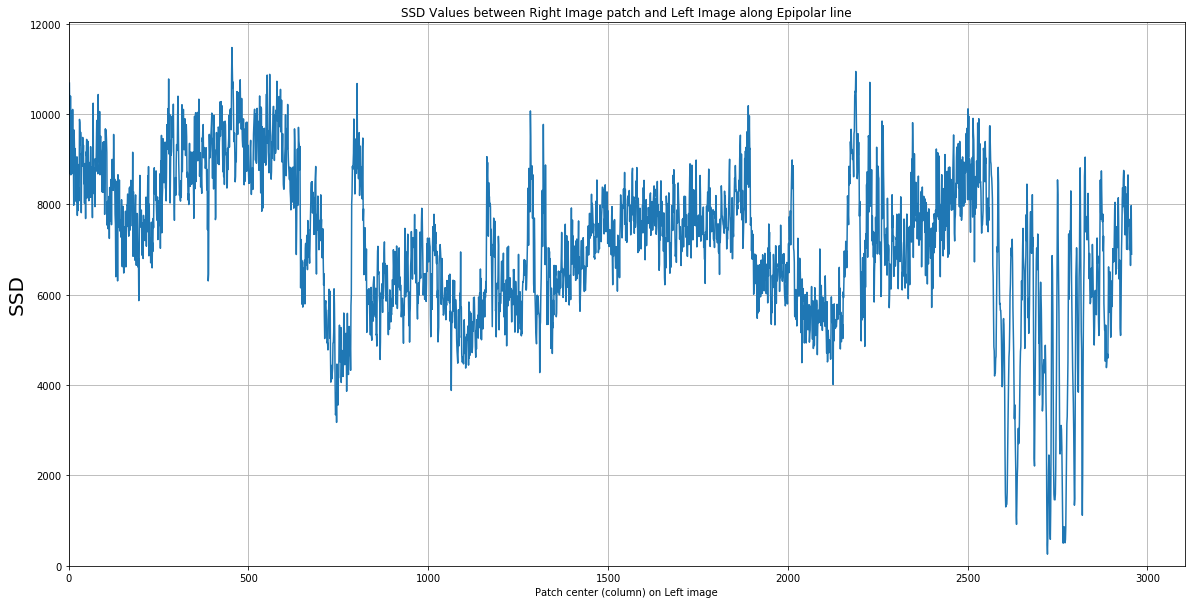

The center of the best_match patch is at column 2722


In [171]:
# Plot SSD Values
patch_size = (5, 5)

plt.figure(figsize=(20,10))
plt.title("SSD Values between Right Image patch and Left Image along Epipolar line")
plt.xlabel("Patch center (column) on Left image")
plt.ylabel("SSD", fontsize=20)
x_axis = range(patch_size[0] // 2, imgL.shape[1] - patch_size[1] // 2 - 1)
plt.plot(x_axis, SSD_list)
plt.ylim(ymin=0), plt.xlim(xmin=0)
plt.grid(True)
plt.show()

print("The center of the best_match patch is at column {}".format(min_idx))

###### Did you find exactly one matching point with lowest SSD or multiple? Is the found matching point correct one? Explain why.
I found a unique matching point with the lowest SSD, and it is the correct one. We did a sanity check by verifying a larger patch to give a context to the patch that we are inspecting. In this case, the lowest value is found near an edge (which mean it has more distinct texture). However, this image is rather low texture, SSD does not always work, as there may be a lot of small atenuation in the color variation which is noisy in the when computing SSD. Therefore, in general, using SSD has the single cost function may not be enough. 

###### Suppose you found multiple matches in the previous question. What constraint(s) could be imposed on the matching algorithm to find a single match?
We could add smoothness to matching cost equation in order to ensure the disparity within local neighbourhoods. This is essentially adding regularization to the cost equation. 


###### Suppose you found exactly one match with the lowest SSD, but it is incorrect one. What constraint(s) could be imposed to find a correct match?
If the lowest SSD is not the correct match, then it means that the cost function is probably not properly defined. We could choose another cost function. Certain factor (such as disparity, smoothness 